In [1]:
#!/usr/bin/python  
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import sys  
import os      
import pandas as pd   
%matplotlib inline

In [2]:
# The face data set is downloaded from http://www.hcii-lab.net/data/SCUT-FBP/CN/download.html
# Crop face region and save to new folder "Faces"
img_dir = "./beautyRate"
xml_file="haarcascade_frontalface_alt.xml"  
xml_path=os.path.join(img_dir,xml_file)
hc=cv2.CascadeClassifier(xml_path) 
faceImagesPath = os.path.join(img_dir,"Faces")

for root, dirs, files in os.walk(img_dir): 
     for name in files:  
            if not name.endswith((".jpg")):  
                continue
            faceLocation = os.path.join(faceImagesPath,name)
            # If face image has existed
            if os.path.isfile(faceLocation):
                continue
            location = os.path.join(root,name)
            img=cv2.imread(location)    
            if img is None:  
                continue 
            faces=hc.detectMultiScale(img) 
            for face in faces:
                imgROI = img[face[1]:face[1]+face[3],face[0]:face[0]+face[2]]
            cv2.imwrite(faceLocation,imgROI)  

In [3]:
#load labels csv
label_data = pd.io.parsers.read_csv(
    './beautyRate/Rating_Collection/Attractivenesslabel.csv',
    )
label_data.head(10)

,Image,Attractiveness label
0,1,2.614
1,2,3.357
2,3,2.458
3,4,2.757
4,5,2.493
5,6,2.620
6,7,2.817
7,8,2.229
8,9,3.000
9,10,3.194


In [4]:
# check one lable
label_data['Attractiveness label'][label_data.Image == 1].tolist()[0]

2.614

In [5]:
# output the mean rate
mean_rate = label_data['Attractiveness label'].mean()
print mean_rate

2.693968


In [6]:
#load input and labels
img_dir = "./beautyRate/Faces"
list_of_imgs = []
list_of_labels = []

for root, dirs, files in os.walk(img_dir): 
    for name in files:   
        if not name.endswith((".jpg")):  
                continue
        location = os.path.join(root,name)
        image = cv2.imread(location)
        if image is None:
            print "Unable to read image", img
            continue
        resized_image = cv2.resize(image, (128, 128)) 
        gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        numberStr = name.split('.')[0]
        number = [int(s) for s in numberStr.split('-') if s.isdigit()]
        if(len(number) > 0) :
            list_of_imgs.append(gray_image.flatten())
            y_label = [label_data['Attractiveness label'][label_data.Image == number[0]].tolist()[0]]
            # The rate value is in range(0, 10), multiply by 10 to make it in (0, 100)
            y_label[0] = y_label[0]*10
            list_of_labels.append(y_label)
images = np.array(list_of_imgs)
labels = np.array(list_of_labels)

In [7]:
# Make sure the counts of inputs and labels are same
pattern_count = images.shape[0]
labels.reshape(pattern_count, 1)
print labels.shape
print images.shape
# Add ops to save and restore all the variables.
#saver = tf.train.Saver()

(499, 1)
(499, 16384)


The face rate for this image is: [ 43.29]


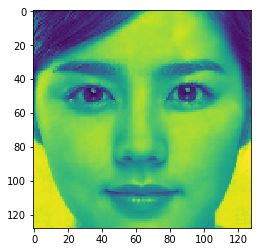

In [8]:
# Use the first 450 images as train data, the left 49 images as test data
train_images = images[0:450]
train_labels = labels[0:450]

test_images = images[450:]
test_labels = labels[450:]

# Display one image
array = train_images[0].reshape(128,128) # convert to 2-D array and display an image
plt.imshow(array)

print "The face rate for this image is:", train_labels[0]

In [12]:
x = tf.placeholder(tf.float32,(None,16384))
y = tf.placeholder(tf.float32,(None,1))

keep_prob = tf.placeholder(tf.float32)

# Train 5 images one time
batch_size = 5
n_batch = len(train_images) // batch_size
test_n_batch = len(test_images) // batch_size

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.001)
    return tf.Variable(initial)

    
def bias_variable(shape):
    initial = tf.constant(0.001, shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1],padding="SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")

def max_pool_4x4(x):
    return tf.nn.max_pool(x, ksize=[1,4,4,1], strides=[1,4,4,1], padding="SAME")

def max_pool_8x8(x):
    return tf.nn.max_pool(x, ksize=[1,8,8,1], strides=[1,8,8,1], padding="SAME")

def max_pool_16x16(x):
    return tf.nn.max_pool(x, ksize=[1,16,16,1], strides=[1,16,16,1], padding="SAME")

x_image = tf.reshape(x,[-1, 128, 128, 1])

W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])

h_conv1= tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_16x16(h_conv1)

# the first full connection layer, with relu activation
W_fc1 = weight_variable([32*8*8, 100])
b_fc1 = bias_variable([100])

h_pool_flat = tf.reshape(h_pool1, [-1, 32*8*8])
h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)

# the second full connection layer, with relu activation
W_fc2 = weight_variable([100, 1])
b_fc2 = bias_variable([1])

prediction =  tf.matmul(h_fc1,W_fc2) + b_fc2
loss = tf.reduce_mean(tf.square(y - prediction))
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=prediction))
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)

save_path =  "./face_rate_trained_model"
# If we did not save a model for this CNN, train the networks
if not os.path.isfile(save_path):
    with tf.Session() as sess:
        model_saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        for epoch in range(30):
            mse = 0.0
            # Train
            for batch in range(n_batch):
                batch_xs = train_images[batch*batch_size: (batch+1)*batch_size]
                batch_ys = train_labels[batch*batch_size: (batch+1)*batch_size]
                sess.run(train_step,feed_dict ={x:batch_xs, y:batch_ys})
            # Test and output MSE
            for batch in range(test_n_batch):
                batch_xs = test_images[batch*batch_size: (batch+1)*batch_size]
                batch_ys = test_labels[batch*batch_size: (batch+1)*batch_size]
                error = sess.run(loss,feed_dict ={x:batch_xs, y:batch_ys})
                mse = mse + float(error)
            mse = mse / len(test_images)
            print "Iter: ", epoch, ", MSE: ", mse 
        model_saver.save(sess, save_path)
        print("Model saved in file: %s" % save_path)

Iter:  0 , MSE:  10.1580013548
Iter:  1 , MSE:  10.8999040175
Iter:  2 , MSE:  10.8175214651
Iter:  3 , MSE:  10.6499573844
Iter:  4 , MSE:  10.4544892214
Iter:  5 , MSE:  10.2280664249
Iter:  6 , MSE:  10.0083540313
Iter:  7 , MSE:  9.79690637394
Iter:  8 , MSE:  9.17876870292
Iter:  9 , MSE:  8.47359855808
Iter:  10 , MSE:  7.92995032486
Iter:  11 , MSE:  6.93107367535
Iter:  12 , MSE:  6.44007023013
Iter:  13 , MSE:  6.2361780478
Iter:  14 , MSE:  6.34816504498
Iter:  15 , MSE:  6.5579097125
Iter:  16 , MSE:  6.26036649821
Iter:  17 , MSE:  6.14976770051
Iter:  18 , MSE:  6.45429019539
Iter:  19 , MSE:  6.54992738062
Iter:  20 , MSE:  6.60519420857
Iter:  21 , MSE:  6.49325929369
Iter:  22 , MSE:  6.60937836705
Iter:  23 , MSE:  6.57357799764
Iter:  24 , MSE:  6.70192492738
Iter:  25 , MSE:  6.70180211748
Iter:  26 , MSE:  6.68174658016
Iter:  27 , MSE:  6.70881335589
Iter:  28 , MSE:  6.67320590117
Iter:  29 , MSE:  6.88714735849
Model saved in file: ./face_rate_trained_model


In [20]:
# Crop face region and predict its rate
img_dir = "./beautyRate/PredictImages"
list_of_imgs = []
list_of_imgs_names = []

for root, dirs, files in os.walk(img_dir): 
     for name in files:  
            if not name.endswith((".jpg")):  
                continue
            location = os.path.join(root,name)
            img=cv2.imread(location)    
            if img is None:  
                continue 
            faces=hc.detectMultiScale(img) 
            for face in faces:
                imgROI = img[face[1]:face[1]+face[3],face[0]:face[0]+face[2]]
            resized_image = cv2.resize(imgROI, (128, 128)) 
            gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
            list_of_imgs.append(gray_image.flatten())
            list_of_imgs_names.append(name) 
predict_images = np.array(list_of_imgs)

This is the face that we will predict its rate: YourFace.jpg


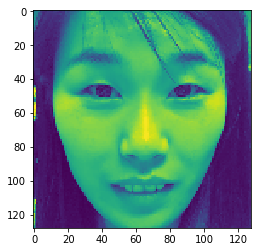

In [21]:
# Display the first image in ./beautyRate/PredictImages

if len(list_of_imgs) > 0 :
    
    array = predict_images[0].reshape(128,128) # convert to 2-D array and display an image
    plt.imshow(array)
    print "This is the face that we will predict its rate:", list_of_imgs_names[0]

In [22]:
# Load model and test, refer to https://github.com/panchishin/learn-to-tensorflow/blob/master/solutions/06-save.py

with tf.Session() as sess:
    new_saver = tf.train.Saver()
    new_saver.restore(sess, save_path)    
    batch_xs = predict_images[0]
    batch_xs = np.reshape(batch_xs,(1, 16384))
    predicted_rate =  sess.run(prediction,feed_dict ={x:batch_xs})
    print "The mean face rate in training images is ", mean_rate*10
    print "The predicted rate for the face in image:", list_of_imgs_names[0], "is", predicted_rate[0][0]
   

INFO:tensorflow:Restoring parameters from ./face_rate_trained_model
The mean face rate in training images is  26.93968
The predicted rate for the face in image: YourFace.jpg is 43.3654
